<a href="https://colab.research.google.com/github/lorenzkap/lecture/blob/main/lecture2_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Example: The GridWorld Environment

Let's make the MDP concept concrete with a classic example: navigating a GridWorld.

Imagine a 10x10 grid. The Agent starts at the top-left cell (State 0) and wants to reach the goal at the bottom-right cell (State 99). The available actions in any cell are Left, Right, Up, Down.


In [30]:
!pip install tabulate

In [31]:
# Helper function to visualize the state index map
import numpy as np
from tabulate import tabulate

def print_state_index_map(size):
    state_map = np.arange(size * size).reshape(size, size)
    print(f"\nState Index Map ({size}x{size}):")
    table = tabulate(state_map, tablefmt="grid", numalign="right")
    print(table)

print_state_index_map(size=10)


State Index Map (10x10):
+----+----+----+----+----+----+----+----+----+----+
|  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
+----+----+----+----+----+----+----+----+----+----+
| 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
+----+----+----+----+----+----+----+----+----+----+
| 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 |
+----+----+----+----+----+----+----+----+----+----+
| 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 |
+----+----+----+----+----+----+----+----+----+----+
| 40 | 41 | 42 | 43 | 44 | 45 | 46 | 47 | 48 | 49 |
+----+----+----+----+----+----+----+----+----+----+
| 50 | 51 | 52 | 53 | 54 | 55 | 56 | 57 | 58 | 59 |
+----+----+----+----+----+----+----+----+----+----+
| 60 | 61 | 62 | 63 | 64 | 65 | 66 | 67 | 68 | 69 |
+----+----+----+----+----+----+----+----+----+----+
| 70 | 71 | 72 | 73 | 74 | 75 | 76 | 77 | 78 | 79 |
+----+----+----+----+----+----+----+----+----+----+
| 80 | 81 | 82 | 83 | 84 | 85 | 86 | 87 | 88 | 89 |
+----+----+----+----+----+----+----+--

**Reward Structure:** To encourage the agent to find the *shortest* path, we define the rewards as follows:
*   Reaching the goal state (99): **+10 reward**.
*   Taking any other step (Left, Right, Up, Down) that doesn't reach the goal: **-1 reward**.

This small negative reward for each step incentivizes minimizing the number of steps taken.

In [32]:
# Helper function to visualize the reward map
def print_reward_map_table(size):
    reward_map = np.full((size, size), -1, dtype=int)
    goal_state_index = size * size - 1
    goal_row = goal_state_index // size
    goal_col = goal_state_index % size
    reward_map[goal_row, goal_col] = 10
    print(f"\nReward Map ({size}x{size}):")
    table = tabulate(reward_map, tablefmt="grid", numalign="right")
    print(table)

print_reward_map_table(size=10)


Reward Map (10x10):
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+--

### Implementing the GridWorld Environment

Let's code this environment using NumPy and Matplotlib for plotting.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    """
    A simple 10x10 GridWorld environment.
    Agent starts at state 0 (top-left) and aims to reach state 99 (bottom-right).
    Actions: 0=Left, 1=Right, 2=Up, 3=Down.
    Reward: +10 for reaching the goal, -1 for all other steps.
    """
    def __init__(self, size=10):
        self.size = size
        self.goal_state = size * size - 1
        self.reset() # Initialize agent position

    def reset(self):
        """Resets the agent to the starting position (state 0)."""
        self.agent_position = 0
        return self.agent_position

    def step(self, action):
        """
        Takes an action, updates the agent's position, and returns the outcome.

        Args:
            action (int): The action taken by the agent (0, 1, 2, 3).

        Returns:
            tuple: A tuple containing:
                - int: The new state (agent's position).
                - int: The reward received.
                - bool: Whether the episode has ended (goal reached).
        """
        current_pos = self.agent_position
        row, col = current_pos // self.size, current_pos % self.size

        # Calculate potential next position based on action
        if action == 0 and col > 0:  # Left
            self.agent_position -= 1
        elif action == 1 and col < self.size - 1:  # Right
            self.agent_position += 1
        elif action == 2 and row > 0:  # Up
            self.agent_position -= self.size
        elif action == 3 and row < self.size - 1:  # Down
            self.agent_position += self.size
        # If action would move off-grid, agent_position remains unchanged.

        # Check if the goal is reached
        done = (self.agent_position == self.goal_state)
        reward = 10 if done else -1

        return self.agent_position, reward, done

#### Understanding the `GridWorld` Class:

*   **`__init__(self, size=10)`**: Sets up the grid size and immediately calls `reset()` to place the agent at the start (state 0).
*   **`reset(self)`**: Puts the agent back at position 0. This is crucial for starting new learning episodes.
*   **`step(self, action)`**: This is the core interaction method:
    *   It takes the agent's chosen `action` (0, 1, 2, or 3).
    *   It calculates the potential new position.
    *   **Boundary Checks:** Crucially, it includes checks (`col > 0`, `col < self.size - 1`, etc.) to ensure the agent doesn't move off the grid. If a move is invalid, the agent stays put.
    *   It determines the `reward`: +10 if the new position is the goal state, -1 otherwise.
    *   It sets the `done` flag to `True` if the goal is reached, `False` otherwise.
    *   It returns the `next_state` (the agent's new position), the `reward`, and the `done` flag.

In [34]:
def get_action(Q, state, epsilon):
    """
    Selects an action using an epsilon-greedy policy based on Q-values.

    Args:
        Q (np.array): The Q-table (states x actions).
        state (int): The current state index.
        epsilon (float): The probability of choosing a random action (exploration).

    Returns:
        int: The index of the chosen action (0, 1, 2, or 3).
    """
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        action_idx = np.random.randint(0, Q.shape[1]) # Q.shape[1] is num_actions
    else:
        # Exploit: choose the action with the highest Q-value for the current state
        action_idx = np.argmax(Q[state])
    return action_idx

The main Q-learning function, but with 2 dimensional input and fitting action space.

In [35]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    """
    Implements the Q-learning algorithm for a discrete state/action environment.

    Args:
        env (GridWorld): The environment instance.
        episodes (int): The total number of episodes to train for.
        alpha (float): The learning rate.
        gamma (float): The discount factor.
        epsilon (float): The exploration rate for epsilon-greedy action selection.

    Returns:
        tuple: A tuple containing:
            - np.array: The learned Q-table.
            - list: A list of total rewards obtained in each episode.
    """
    num_states = env.size * env.size
    num_actions = 4 # L, R, U, D

    # Initialize the Q-table with zeros
    Q = np.zeros((num_states, num_actions))

    # List to store total reward per episode
    rewards_per_episode = []

    # Main training loop over episodes
    for ep in range(episodes):
        state = env.reset() # Start episode at the beginning state
        total_reward = 0
        done = False

        # Loop for each step within an episode
        while not done:
            # 1. Choose action using epsilon-greedy
            action_idx = get_action(Q, state, epsilon)

            # 2. Take action and observe outcome
            next_state, reward, done = env.step(action_idx)
            total_reward += reward

            # 3. Update the Q-value for the (state, action) pair
            # Calculate the TD Target: R + gamma * max_a'(Q(S', a'))
            # Note: If next_state is terminal (done=True), its value is 0.
            # We handle this implicitly because Q[terminal_state,:] remains 0.
            # Alternatively, explicitly check 'done': target = reward + gamma * np.max(Q[next_state]) * (1 - done)
            target_q_value = reward + gamma * np.max(Q[next_state])

            # Calculate TD Error: target - old_value
            # old_q_value = Q[state, action_idx]
            # td_error = target_q_value - old_q_value

            # Update Q-value: Q(S, A) <- Q(S, A) + alpha * TD_Error
            # Q[state, action_idx] = old_q_value + alpha * td_error

            # Combined update rule
            Q[state, action_idx] += alpha * (target_q_value - Q[state, action_idx])

            # 4. Move to the next state
            state = next_state

        # Episode finished, record total reward
        rewards_per_episode.append(total_reward)

    return Q, rewards_per_episode


### Running the Q-Learning Simulation

Alright, we have the `GridWorld` environment and the `q_learning` function. Let's run the simulation!


In [36]:
# Set seed for reproducibility
np.random.seed(42)

env = GridWorld(size=10)
num_episodes_q = 500
alpha_q = 0.1
gamma_q = 0.99 # Discount factor - value future rewards highly
epsilon_q = 0.1

print(f"--- Running Q-Learning ---")
print(f"Episodes: {num_episodes_q}, Alpha: {alpha_q}, Gamma: {gamma_q}, Epsilon: {epsilon_q}")

# --- Run Q-Learning ---
q_table_final, q_rewards_list = q_learning(
    env,
    episodes=num_episodes_q,
    alpha=alpha_q,
    gamma=gamma_q,
    epsilon=epsilon_q
)
print(f"Q-Learning finished after {len(q_rewards_list)} episodes.")

--- Running Q-Learning ---
Episodes: 500, Alpha: 0.1, Gamma: 0.99, Epsilon: 0.1
Q-Learning finished after 500 episodes.
Q-Learning finished after 500 episodes.


#### Visualizing Q-Learning Performance

Raw episode rewards can be noisy. Let's smooth them using a moving average to see the learning trend.


Optimal reward for 10x10 grid: -7


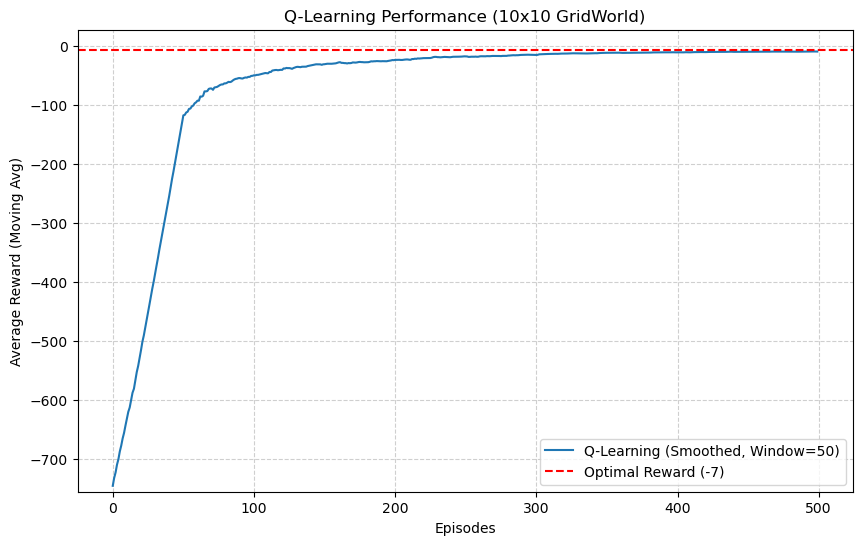

In [ ]:
# Helper function for smoothing rewards
def moving_average(x, window=50):
    # Pad beginning with first value to handle initial window size
    padded_x = np.pad(x, (window-1, 0), mode='edge')g
    # Calculate rolling mean
    y = np.convolve(padded_x, np.ones(window)/window, mode='valid')
    # Convert back to list of Python floats
    return [float(val) for val in y]

# --- Calculate Smoothed Rewards & Optimal Value ---
q_rewards_smoothed = moving_average(q_rewards_list, window=50)

# Calculate optimal reward for plotting reference (shortest path)
shortest_path_len = 2 * (env.size - 1)
optimal_reward = (shortest_path_len - 1) * (-1) + 10 # (Num steps - 1)*(-1) + 1*(+10)
print(f"\nOptimal reward for {env.size}x{env.size} grid: {optimal_reward}")

# --- Plotting Q-Learning Performance ---
plt.figure(figsize=(10, 6))
plt.plot(q_rewards_smoothed, label=f"Q-Learning (Smoothed, Window=50)")
plt.axhline(y=optimal_reward, color='red', linestyle='--', label=f'Optimal Reward ({optimal_reward})')
plt.xlabel("Episodes")
plt.ylabel("Average Reward (Moving Avg)")
plt.title(f"Q-Learning Performance ({env.size}x{env.size} GridWorld)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
min_reward_smoothed = min(q_rewards_smoothed) if q_rewards_smoothed else optimal_reward - 20
plt.ylim(bottom=min(min_reward_smoothed - 10, optimal_reward - 20) )
plt.show()